# Анализ данных в задаче кредитного скоринга

In [30]:
import numpy as np
import pandas as pd

import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [63]:
data = pd.read_csv('credit_card_default_analysis.csv')

## Размер кредитного лимита (LIMIT_BAL)

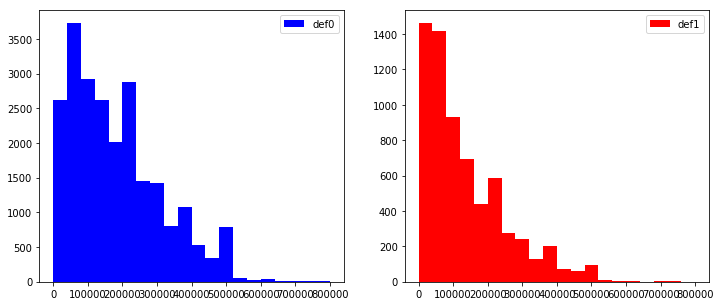

In [25]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.default==0].LIMIT_BAL, bins = 20, color = 'b', range = (0, 800000), label = 'def0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.default==1].LIMIT_BAL, bins = 20, color = 'r', range = (0, 800000),label = 'def1')
pylab.legend()

pylab.show()

### Интервальная оценка разности медиан на основе bootstrap

* $H_0$: медианные значения равны


* $H_1$: медианные значения отличаются

In [4]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [10]:
np.random.seed(0)

d0_median_scores = map(np.median, get_bootstrap_samples(data[data.default==0].LIMIT_BAL.values, 1000))
d1_median_scores = map(np.median, get_bootstrap_samples(data[data.default==1].LIMIT_BAL.values, 1000))

delta_median_scores = map(lambda x: x[0] - x[1], zip(d0_median_scores, d1_median_scores))

print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [60000. 70000.]


### Перестановочный критерий (непараметрический критерий проверки равенства средних) 
Выборки независимы, так как имеют различные объекты 

* $H_0\colon F_{X_1}(x) = F_{X_2}(x)$


* $H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [11]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_combinations):
    index = range(n1 + n2)
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    t_stat = permutation_t_stat_ind(sample, mean)
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)

In [13]:
np.random.seed(0)
print "p-value: %f" % permutation_test(data[data.default==0].LIMIT_BAL, data[data.default==1].LIMIT_BAL, max_permutations = 10000)

p-value: 0.000100


*Вывод: 95% доверительный интервал для разности медиан лежит в промежутке между 60000 и 70000, нулевая гипотеза о равенстве распределений отвергается на уровне значимости 0.05, что говорит о том, что есть значимые отличия между размерами кредитного лимита. Результат практически значим, так как разница довольно большая и логически верна.*

## Пол (SEX)

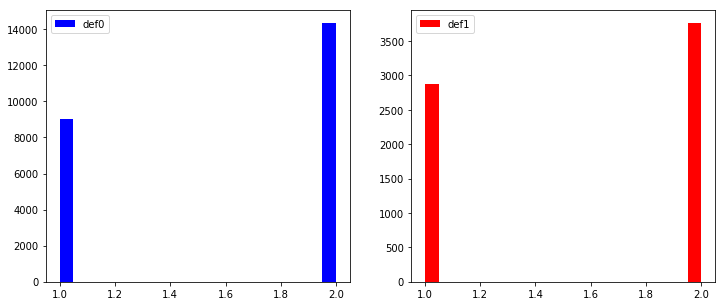

In [26]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.default==0].SEX, bins = 20, color = 'b', range = (1, 2), label = 'def0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.default==1].SEX, bins = 20, color = 'r', range = (1, 2),label = 'def1')
pylab.legend()

pylab.show()

* $H_0$: Гендерный состав групп не отличается


* $H_1$: Гендерный состав отличается

### Интервальная оценка. Z-критерий для разности долей (независимые выборки) 

In [31]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [33]:
print "95%% confidence interval for a difference between proportions: [%f, %f]" %\
      proportions_diff_confint_ind(data[data.default==0].SEX==2, data[data.default==1].SEX==2)

95% confidence interval for a difference between proportions: [0.033635, 0.060548]


### 𝑍−статистика. Z-критерий для разности долей (независимые выборки) 

In [34]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [38]:
print "p-value:", proportions_diff_z_test(proportions_diff_z_stat_ind(data[data.default==0].SEX==2, data[data.default==1].SEX==2))

p-value: 4.472866521609831e-12


*Вывод: 95% доверительный интервал для разности долей лежит в промежутке между 0.033635 и 0.060548, нулевая гипотеза о равенстве долей отвергается на уровне значимости 0.05, что говорит о том, что есть отличия между полами двух групп. Результат практически вряд ли значим, так как разница довольно маленькая (3-6%) и логически не совсем интуитивна.*

## Образование (EDUCATION)

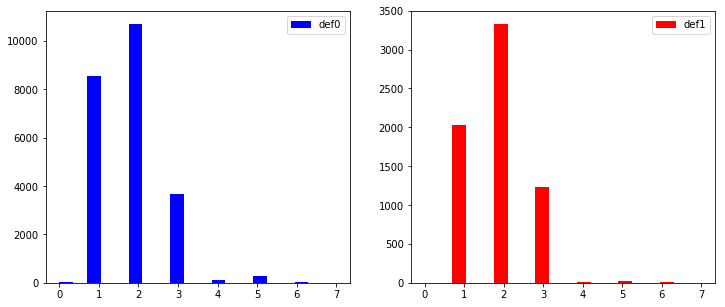

In [42]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.default==0].EDUCATION, bins = 20, color = 'b', range = (0, 7), label = 'def0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.default==1].EDUCATION, bins = 20, color = 'r', range = (0, 7),label = 'def1')
pylab.legend()

pylab.show()

Text(0.5,1,'The rate of repay in each group')

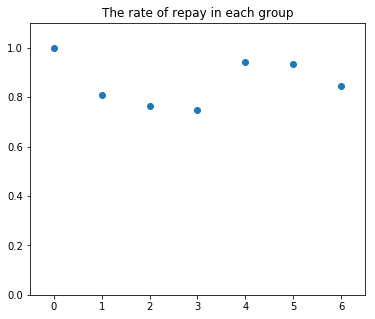

In [71]:
proportion0 = 1.*np.bincount(data[data.default==0].EDUCATION)/np.bincount(data.EDUCATION)

pylab.figure(figsize = (6,5))
pylab.axis([-0.5, 6.5, 0, 1.1])
pylab.scatter(range(7), proportion0)
pylab.title('The rate of repay in each group')

### Критерий согласия Пирсона ( $\chi^2$)

* $H_0$: Рассматриваемая величина имеет Равномерное распределение 


* $H_1$: $H_0$ неверна

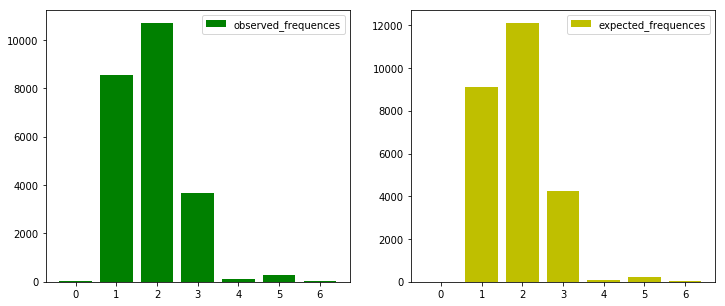

In [76]:
observed_frequences = np.bincount(data[data.default==0].EDUCATION)
expected_frequences = proportion0.mean()*np.bincount(data.EDUCATION)

pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.bar(range(7), observed_frequences, color = 'g', label = 'observed_frequences')
pylab.legend()

pylab.subplot(1,2,2)
pylab.bar(range(7), expected_frequences, color = 'y', label = 'expected_frequences')
pylab.legend()

pylab.show()

In [68]:
stats.chisquare(observed_frequences, expected_frequences, ddof = 1)

Power_divergenceResult(statistic=278.7725391716089, pvalue=3.653181595163598e-58)

*Вывод: Нулевая гипотеза отвергается на уровне значимости 0.05, что говорит о том, что есть отличия между выплатой кредита разными группами. Результат практически значим, так как разница довольно существенная и логически интуитивна.*

## Семейное положение (MARRIAGE)

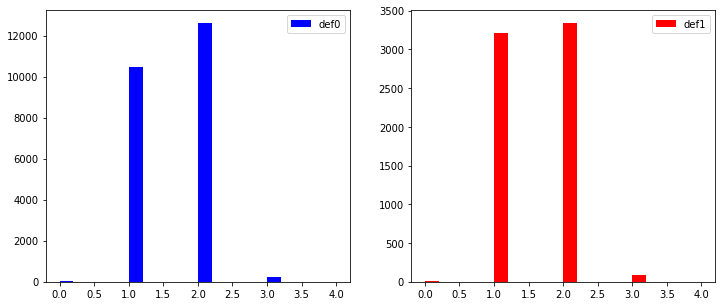

In [78]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.default==0].MARRIAGE, bins = 20, color = 'b', range = (0, 4), label = 'def0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.default==1].MARRIAGE, bins = 20, color = 'r', range = (0, 4),label = 'def1')
pylab.legend()

pylab.show()

### Коэффициент V Крамера

In [87]:
contingency_table = np.zeros((4, 2))
for i in range(4):
    contingency_table[i, 0] = np.bincount(data[data.default==0].MARRIAGE)[i]
    contingency_table[i, 1] = np.bincount(data[data.default==1].MARRIAGE)[i]
contingency_table

array([[4.9000e+01, 5.0000e+00],
       [1.0453e+04, 3.2060e+03],
       [1.2623e+04, 3.3410e+03],
       [2.3900e+02, 8.4000e+01]])

In [90]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2/(n*(min(confusion_matrix.shape)-1)))

In [91]:
cramers_stat(contingency_table)

0.034478203662766466

*Вывод: Коэффицент V Крамера равен примерно 0.034, что очень близко к 0. Соттветственно, возврат кредита и признак MARRIAGE мало коррелированы. Результат практически значим, так как говорит, что MARRIAGE не должен влиять на решение о выдаче кредита.*

## Возраст (AGE)

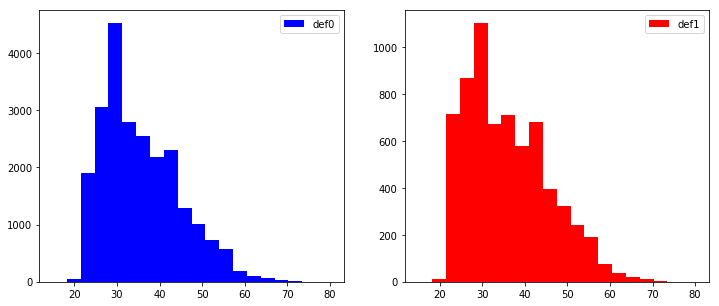

In [95]:
pylab.figure(figsize(12, 5))
pylab.subplot(1,2,1)
pylab.hist(data[data.default==0].AGE, bins = 20, color = 'b', range = (15, 80), label = 'def0')
pylab.legend()

pylab.subplot(1,2,2)
pylab.hist(data[data.default==1].AGE, bins = 20, color = 'r', range = (15, 80),label = 'def1')
pylab.legend()

pylab.show()

### Интервальная оценка разности медиан на основе bootstrap

* $H_0$: медианные значения равны


* $H_1$: медианные значения отличаются

In [96]:
np.random.seed(0)

d0_median_scores = map(np.median, get_bootstrap_samples(data[data.default==0].AGE.values, 1000))
d1_median_scores = map(np.median, get_bootstrap_samples(data[data.default==1].AGE.values, 1000))

delta_median_scores = map(lambda x: x[0] - x[1], zip(d0_median_scores, d1_median_scores))

print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

95% confidence interval for the difference between medians [-1.  0.]


### Перестановочный критерий (непараметрический критерий проверки равенства средних) 
Выборки независимы, так как имеют различные объекты 

* $H_0\colon F_{X_1}(x) = F_{X_2}(x)$


* $H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [97]:
np.random.seed(0)
print "p-value: %f" % permutation_test(data[data.default==0].AGE, data[data.default==1].AGE, max_permutations = 10000)

p-value: 0.015100


*Вывод: 95% доверительный интервал для разности медиан лежит в промежутке между -1 и 0 и содержит 0. Значит, медианы двух групп равны. Тем не менее, нулевая гипотеза о равенстве распределений отвергается на уровне значимости 0.05, что говорит о том, что есть отличия. Результат практически значим, так как возраст влияет на выдачу кредита клиенту.*